Max mu : 10
mus : [0.8236475079774124, 0.9103565379264364, 0.16456579813368521, 0.17732884646626457, 0.278880109331201, 0.20347655804192266, 0.042301665932029664, 0.06826925550564478, 0.3618283907762174, 0.9732164043865108]
Policy : RandomSelect
Cumulative Reward : 4170.317924041474
Select Count : [965, 1030, 966, 962, 1056, 1002, 993, 991, 1007, 1028]
Max Select : 5
Policy : EpsilonGreedy(0.05)
Cumulative Reward : 9456.38518219278
Select Count : [276, 143, 51, 48, 53, 58, 59, 42, 51, 9219]
Max Select : 10
Policy : EpsilonGreedy(0.1)
Cumulative Reward : 8569.052701328705
Select Count : [216, 8977, 97, 103, 103, 110, 97, 92, 104, 101]
Max Select : 2
Policy : Softmax(0.05)
Cumulative Reward : 9649.413609089614
Select Count : [2, 1634, 1, 1, 2, 2, 1, 1, 1, 8355]
Max Select : 10
Policy : Softmax(0.1)
Cumulative Reward : 9558.531371804893
Select Count : [2, 2975, 1, 2, 9, 2, 2, 1, 1, 7005]
Max Select : 10
Policy : UCB1
Cumulative Reward : 9502.40326940183
Select Count : [119, 297, 22, 18, 2

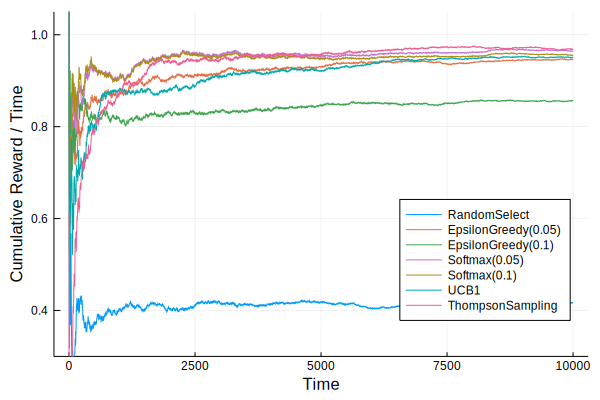

In [1]:
using Random
using Statistics
using StatsBase
using Distributions
using Plots

mutable struct State
    cnt::Int
    n_arms::Int
    sum_reward::Float64
    cum_reward_history::AbstractArray{Float64}
    cnt_per_arms::AbstractArray{Int}
    mus::AbstractArray{Float64}
end

abstract type Policy end

# RandomSelect
struct RandomSelect <: Policy end

function select(rng::RandomSelect, state::State)::Int
    rand(1:state.n_arms)
end

function update(rng::RandomSelect, state::State, armi, reward)
end

function Base.show(io::IO, rng::RandomSelect)
    print(io, "RandomSelect")
end


# UCB1
struct UCB1 <: Policy
    values::AbstractArray{Float64}
end

function select(ucb::UCB1, state::State)::Int
    if minimum(state.cnt_per_arms) == 0
        return argmin(state.cnt_per_arms)
    end
    bounds = sqrt.(2 * log(state.cnt) ./ state.cnt_per_arms)
    argmax(ucb.values + bounds)
end

function update(ucb::UCB1, state::State, armi, reward)
    n = state.cnt_per_arms[armi]
    ucb.values[armi] = (reward + (n-1) * ucb.values[armi]) / n
end

function Base.show(io::IO, ucb::UCB1)
    print(io, "UCB1")
end


# Softmax
mutable struct Softmax <: Policy
    t::Float64
    values::AbstractArray{Float64}
end

function select(sm::Softmax, state::State)::Int
    if minimum(state.cnt_per_arms) == 0
        return argmin(state.cnt_per_arms)
    end

    xs = [ exp(v/sm.t) for v in sm.values]
    sum_xs = sum(xs)
    ps = [ exp(v/sm.t)/sum_xs for v in sm.values]
    sample(Weights(ps))
end

function update(sm::Softmax, state::State, armi, reward)
    n = state.cnt_per_arms[armi]
    sm.values[armi] = (reward + (n-1) * sm.values[armi]) / n
end

function Base.show(io::IO, sm::Softmax)
    print(io, "Softmax(", sm.t, ")")
end


# EpsilonGreedy
mutable struct EpsilonGreedy <: Policy
    epsilon::Float64
    values::AbstractArray{Float64}
end

function select(eg::EpsilonGreedy, state::State)::Int
    if rand() < eg.epsilon
        rand(1:state.n_arms)
    else
        argmax(eg.values)
    end
end

function update(eg::EpsilonGreedy, state::State, armi, reward)
    n = state.cnt_per_arms[armi]
    eg.values[armi] = (reward + (n-1) * eg.values[armi]) / n
end

function Base.show(io::IO, gb::EpsilonGreedy)
    print(io, "EpsilonGreedy(", gb.epsilon, ")")
end



# ThompsonSampling
mutable struct ThompsonSampling <: Policy
    alpha0::Float64
    beta0::Float64
    mu0::Float64
    v0::Float64
    xs::AbstractVector{AbstractVector{Float64}}
end

function select(ts::ThompsonSampling, state::State)::Int
    samples = []
    for armi in 1:state.n_arms
        d = ts.xs[armi]
        n = length(d)
        mean_d = n == 0 ? 0.0 : mean(d)

        mu = (ts.v0*ts.mu0 + n * mean_d)/(ts.v0 + n)
        v = ts.v0 + n
        alpha = ts.alpha0 + n/2
        beta = ts.beta0 + 1/2*sum([(x - mean_d)^2 for x in d]) + (ts.v0*n*(mean_d - ts.mu0)^2)/(2*(ts.v0 + n))

        gamma = Gamma(alpha, 1/beta)
        lambda_ = rand(gamma)
        normal_mu_ = Normal(mu, sqrt(1/(v * lambda_)) )
        mu_ = rand(normal_mu_)

        push!(samples, mu_)
    end
    argmax(samples)
end

function update(ts::ThompsonSampling, state::State, armi, reward)
    push!(ts.xs[armi], reward)
end

function Base.show(io::IO, ts::ThompsonSampling)
    print(io, "ThompsonSampling")
end


function init_state(n_arms::Int; seed=0)::State
    Random.seed!(seed)
    State(0, n_arms, 0.0, zeros(0), zeros(n_arms), rand(n_arms))
end

function get_reward(state::State, armi)::Float64
    randn() + state.mus[armi]
end

function run(policy::Policy, state::State; n=10000, seed=0)
    Random.seed!(seed)
    for i in 1:n
        state.cnt += 1
        armi = select(policy, state)
        state.cnt_per_arms[armi] += 1
        reward = get_reward(state, armi)
        state.sum_reward += reward
        push!(state.cum_reward_history, state.sum_reward)
        update(policy, state, armi, reward)
    end
end


n_arms = 10
state = init_state(n_arms)

# policy
r = RandomSelect()
eg1 = EpsilonGreedy(0.05, zeros(n_arms))
eg2 = EpsilonGreedy(0.1, zeros(n_arms))
sm1 = Softmax(0.05, zeros(n_arms))
sm2 = Softmax(0.1, zeros(n_arms))
ucb = UCB1(zeros(n_arms))
ts = ThompsonSampling(1,1,0.0,0.00000001,[Vector() for _ in 1:n_arms])
ps = [r eg1 eg2 sm1 sm2 ucb ts]

cum_reward_historys = []
println("Max mu : ", argmax(state.mus))
println("mus : ", state.mus)
for p in ps
    s = deepcopy(state)
    run(p, s)
    println("======================================")
    println("Policy : ", p)
    println("Cumulative Reward : ", s.sum_reward)
    println("Select Count : ", s.cnt_per_arms)
    println("Max Select : ", argmax(s.cnt_per_arms))
    push!(cum_reward_historys, s.cum_reward_history)
end

n = length(cum_reward_historys[1])
v = cum_reward_historys[1] ./ range(1, n, step=1)
for i in 2:length(ps)
    global v
    tmp = cum_reward_historys[i] ./ range(1, n, step=1)
    v = hcat(v, tmp)
end

label = map((x) -> string(x), ps)
plot(v, label = label, ylim=(0.3, 1.05), xlabel="Time", ylabel="Cumulative Reward / Time", legend = :bottomright)